In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

from jax import jacfwd
import jax.numpy as jnp
import copy
# Import interact function from ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
# Import float slider from ipywidgets
from ipywidgets import FloatSlider, IntSlider, widgets

import src.featlin
from src.featlin import Featlin
from src.helper import optimize_cv

import src.basis as basis
from src.basis import BasicsData

plt.style.use('./styles/plots.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = 0
save_path = './results/Linearization/'

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1 
# IBM Colors: https://www.ibm.com/design/language/color/
# https://lospec.com/palette-list/ibm-color-blind-safe

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]
marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

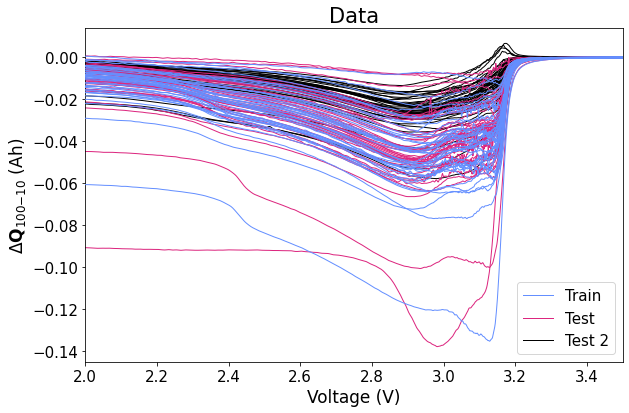

In [5]:
# Make Dataset Plots. 
fig, ax = plt.subplots(figsize=(9,6))
ax = src.helper.plot_x_tt2(X_lfp_train, x_lfp, ax, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], zorder=3)
ax = src.helper.plot_x_tt2(X_lfp_test, x_lfp, ax, colors_IBM[2], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test', zorder=2)
ax = src.helper.plot_x_tt2(X_lfp_test2, x_lfp, ax, colors_IBM[5], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Test 2', zorder=1)
ax.set_title('Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'data.pdf')

In [6]:
# Remove outlier 
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

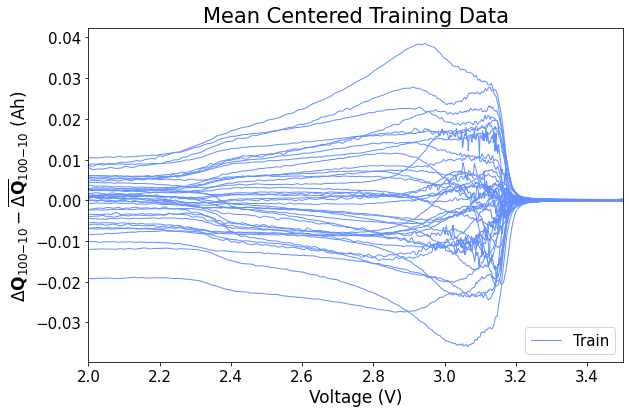

In [7]:
fig, ax = plt.subplots(figsize=(9,6))
ax = src.helper.plot_x_tt2(X_lfp_train-np.mean(X_lfp_train, axis=0), x_lfp, ax, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Train')
ax.set_ylabel(r'$\Delta \mathbf{Q}_{100\mathrm{-}10} - \overline{\Delta \mathbf{Q}}_{100\mathrm{-}10}$ (Ah)')
ax.set_title('Mean Centered Training Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'mctrain.pdf')
plt.show()

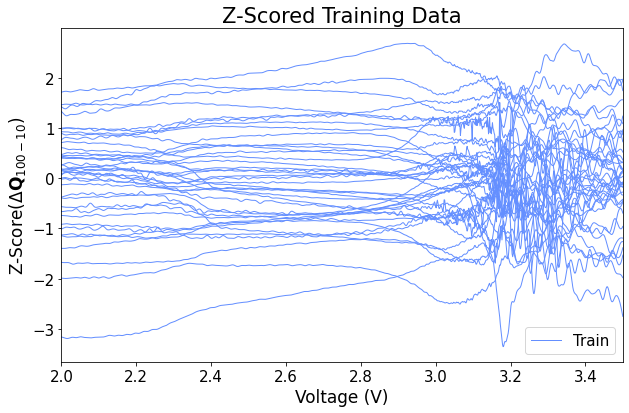

In [8]:
scaler = StandardScaler()
X_zscore = scaler.fit_transform(X_lfp_train)

fig, ax = plt.subplots(figsize=(9,6))
ax = src.helper.plot_x_tt2(X_zscore, x_lfp, ax, colors_IBM[0], labels_lfp['xdata_label'], labels_lfp['ydata_label'], label_data='Train')
ax.set_ylabel(r'Z-Score$(\Delta \mathbf{Q}_{100-10})$')
ax.set_title('Z-Scored Training Data')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'zscoretrain.pdf')
plt.show()

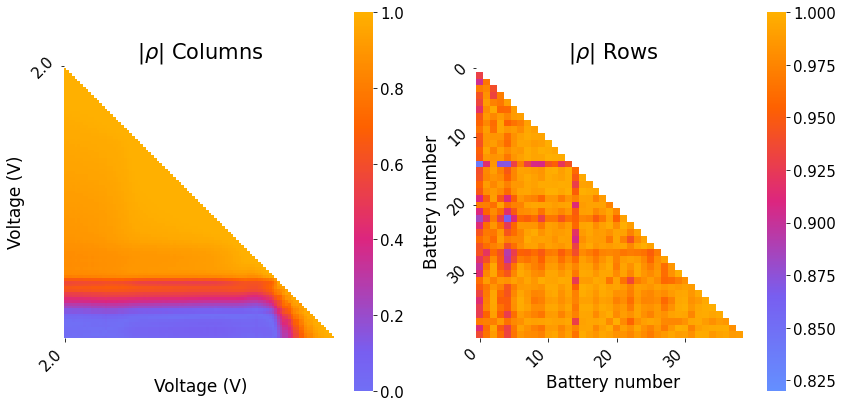

In [9]:
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=y_lfp_train_true) 

# Correlations: 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs = lfp_mean.plot_row_column_corrheatmap(labels_lfp['xdata_label'], labels_lfp['row_label'], axs=axs)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'corr.pdf')

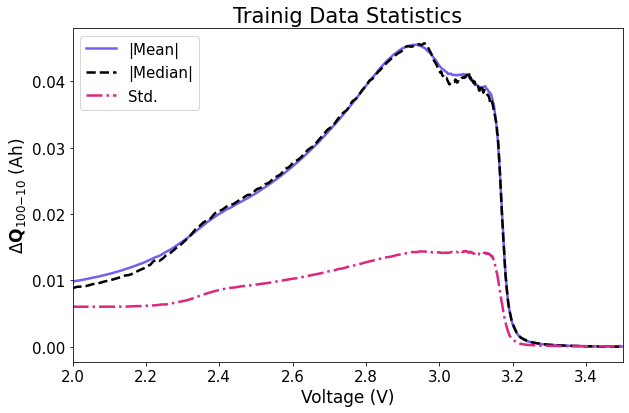

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
axs = lfp_mean.plot_stats(ax, colors_IBM[1], colors_IBM[2], colors_IBM[5], labels_lfp['xdata_label'], labels_lfp['ydata_label'])
ax.set_title('Trainig Data Statistics')
ax.set_xlim(2.0, 3.5)
plt.tight_layout()
if save_plots:
    plt.savefig(save_path + 'stats.pdf')
plt.show()

In [11]:
# Exmaple of how the PLS model approximates the nonlinearity
def polynomial_comb_y(X: np.ndarray, a=114, b=-3) -> np.ndarray:
    Y = -1/100 * (a*X-b)**7 - (a*X-b)**4 - 2*(a*X-b)**2 -4*(a*X-b) 
    if len(Y.shape) == 1:
        y = jnp.sum(Y)
    else:
        y = jnp.sum(Y, axis=1)
    # Increase dimensionality of y
    return y
    
def sinus_transformation(X: np.ndarray, a=0.07) -> np.ndarray:
    Y = jnp.sin((2*jnp.pi/a) * X)
    if len(Y.shape) == 1:
        y = jnp.sum(Y)
    else:
        y = jnp.sum(Y, axis=1)
    return y
    

In [12]:
# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda X: polynomial_comb_y(X, a=95, b=-2.9),
    lambda X: sinus_transformation(X, a=0.06), 
    lambda a : jnp.sum(a**2),
    ]
fun_target_names = [
    'Polynomial Combination',
    'Sinus Transformation',
    'Sum of Squares'
    ]

feat_fun_dict = {fun_target_names[i] : fun_targetj[i] for i in range(len(fun_targetj))}


In [13]:
# Generate BasicsData class objects
# lfp_poly = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
# fp_poly = lfp_poly.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=40)

# lfp_poly = Featlin(data_obj=lfp_poly, feat_funcs=feat_fun_dict)
# y = polynomial_comb_y(x, a=120, b=-2.9)
# plt.plot(x, y)


In [14]:
# Generate BasicsData class objects
lfp_sin = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_sin = lfp_sin.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=40)
# y = sinus_transformation(x)
# plt.plot(x, y)

lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_sums = lfp_sums.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=40)

In [15]:
# Inititate the class with data (x, y) & features that you want to test

lfp_sin = Featlin(data_obj=lfp_sin, feat_funcs=feat_fun_dict)
lfp_sums = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)

In [16]:
if 0:
    def train_PLS_models(X: np.ndarray, y: np.ndarray, n_comp: int) -> list:
        pls_models = []
        for i in range(n_comp):
            pls_models.append(PLSRegression(n_components=i+1))
            pls_models[i].fit(X, y)
        return pls_models

    def plot_PLS_models(pls_models: list, x: np.ndarray, ax: plt.Axes, colors: list, labels: dict) -> plt.Axes:
        for i in range(len(pls_models)):
            ax.plot(x, pls_models[i].coef_, color=colors[i], label='PLS n_comp = ' + str(i+1))
        ax.set_xlabel(labels['xdata_label'])
        ax.set_ylabel(labels['ydata_label'])
        ax.set_title('PLS Regression Coefficients')
        ax.legend()
        return ax

    x = np.linspace(-0.08,0,1000).reshape(-1,1)

    y_poly = polynomial_comb_y(X_lfp_train)
    pls_models_poly = train_PLS_models(X_lfp_train, y_poly, 4)
    fig, ax = plt.subplots(figsize=(9,6))
    labels = {}
    labels['xdata_label'] = labels_lfp['xdata_label']
    labels['ydata_label'] = r'$\beta$'
    plot_PLS_models(pls_models_poly, np.linspace(2.0, 3.5, 1000), ax, colors_IBM, labels)

    y_sin = sinus_transformation(X_lfp_train)
    pls_models_sin = train_PLS_models(X_lfp_train, y_sin, 5)
    fig, ax = plt.subplots(figsize=(9,6))
    labels = {}
    labels['xdata_label'] = labels_lfp['xdata_label']
    labels['ydata_label'] = r'$\Delta \mathbf{Q}_{100\mathrm{-}10} - \overline{\Delta \mathbf{Q}}_{100\mathrm{-}10}$ (Ah)'
    plot_PLS_models(pls_models_sin, np.linspace(2.0, 3.5, 1000), ax, colors_IBM, labels)

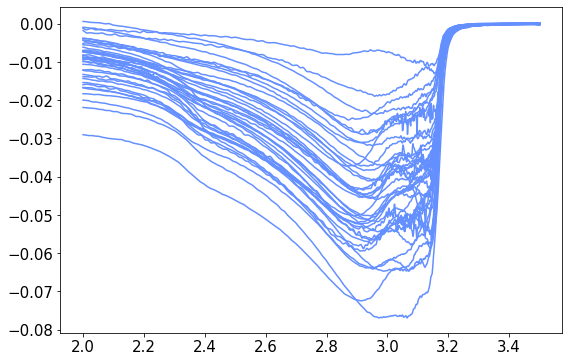

In [17]:
# plot X_lfp_train
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x_lfp, X_lfp_train.T, color=colors_IBM[0], label='X_lfp_train')
plt.show()

In [18]:
# Let's make some examples based on the LFP data
X = X_lfp_train - np.mean(X_lfp_train, axis=0)

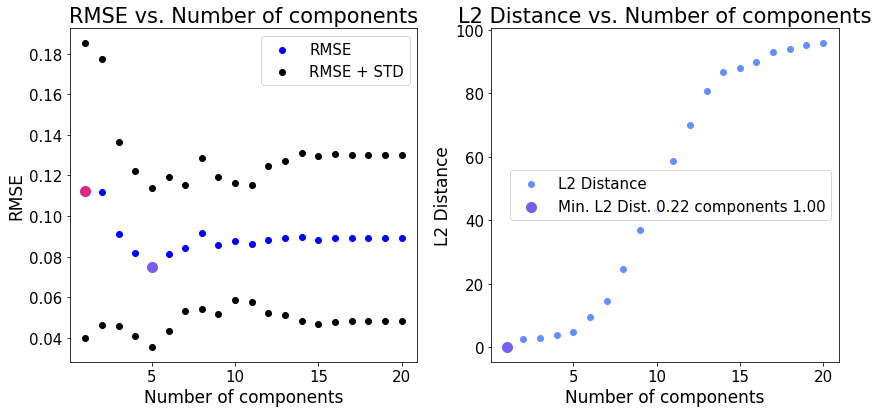

Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations


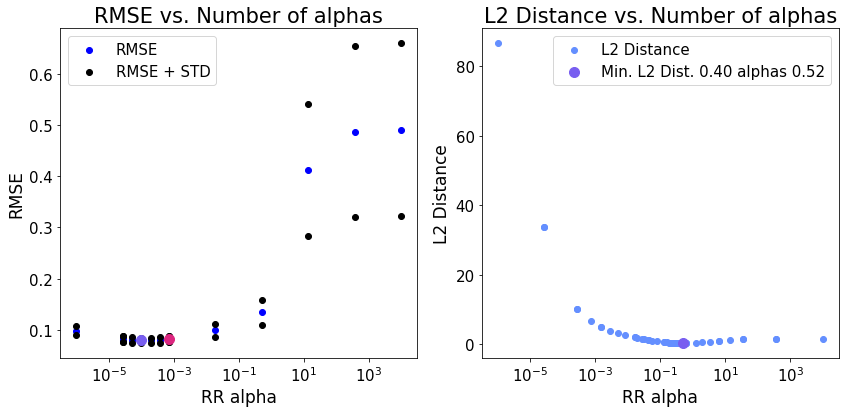

In [19]:
# Poly is some nasty example, that is extremely non-linear and will therefore not be considered further
# x_hat_poly, lin_coef_poly_, lin_const_coef_poly = lfp_poly.regress_linearized_coeff(lfp_poly.feat_fun_dict['Polynomial Combination'], std=0)
# y_poly = copy.deepcopy(lfp_poly.data.y_)

x_hat, lin_coef_sums_, lin_const_coef_sums = lfp_sums.regress_linearized_coeff(lfp_sums.feat_fun_dict['Sum of Squares'], std=0)
y_sums = copy.deepcopy(lfp_sums.data.y_)

res_dict_pls_sums = optimize_cv(X, y_sums, max_comps=20, alpha_lim=[10e-5, 10e3], folds=10, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=True, 
        featlin=lin_coef_sums_, algorithm='PLS', plot=True)

res_dict_rr_sums = optimize_cv(X, y_sums, max_comps=20, alpha_lim=[10e-7, 10e3], folds=10, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=True, 
        featlin=lin_coef_sums_, algorithm='RR', plot=True)

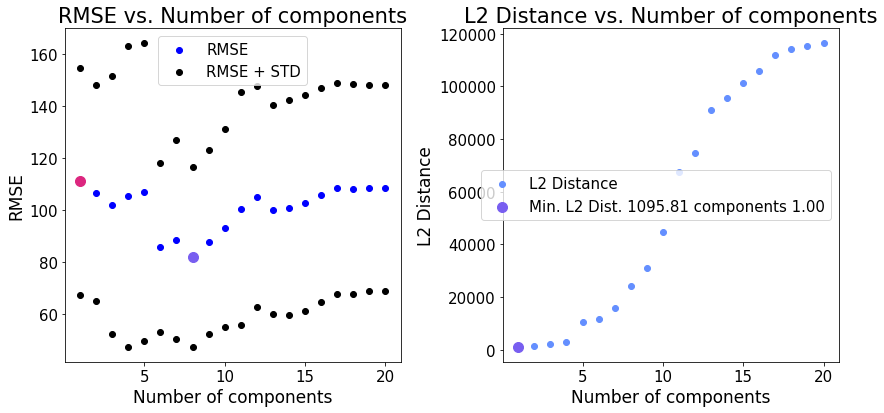

Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations


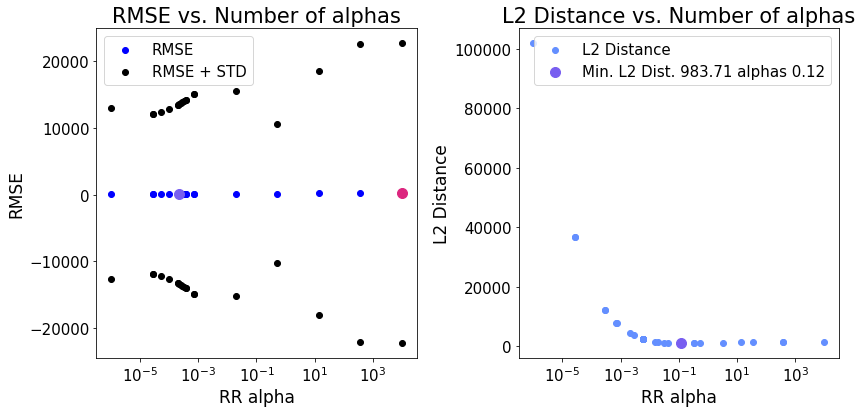

In [20]:
x_hat, lin_coef_sin_, lin_const_coef_sin = lfp_sin.regress_linearized_coeff(lfp_sin.feat_fun_dict['Sinus Transformation'], std=0)
y_sin = copy.deepcopy(lfp_sin.data.y_)

res_dict_pls_sin = optimize_cv(X, y_sin, max_comps=20, alpha_lim=[10e-5, 10e3], folds=10, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=True, 
        featlin=lin_coef_sin_, algorithm='PLS', plot=True)

res_dict_rr_sin = optimize_cv(X, y_sin, max_comps=20, alpha_lim=[10e-7, 10e3], folds=10, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=True, 
        featlin=lin_coef_sin_, algorithm='RR', plot=True)

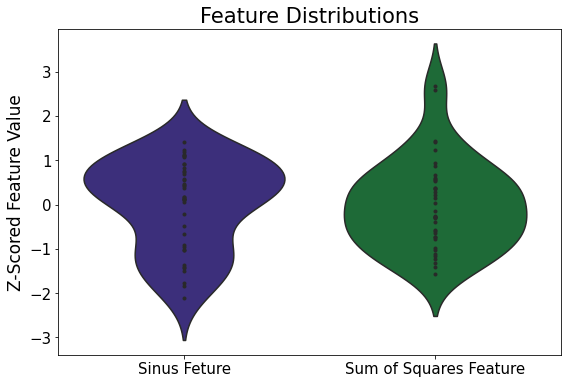

In [21]:
y_sin_df = pd.DataFrame(y_sin)
y_sums_df = pd.DataFrame(y_sums)
# Merge the two dataframes
y_df = pd.concat([y_sin_df, y_sums_df], axis=1)
# Normalize the columns
y_df = (y_df - y_df.mean()) / y_df.std()
# set the column names
y_df.columns = ['Sinus Feture', 'Sum of Squares Feature']

# make a violin plot with two axis (one for each feature)
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(data=y_df, ax=ax, split=True, inner='point', palette=colors)
ax.set_ylabel('Z-Scored Feature Value')
ax.set_title('Feature Distributions')

# Save the figure
fig.savefig('figures/feature_distributions.pdf', bbox_inches='tight')
plt.show()


In [22]:
markers = ['o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 'x', 'o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 'x']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
fmt = [c+m+ls for c in colors for m in markers for ls in linestyles]
colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']
colors = colors[::-1] + colors

In [23]:
def plot_ridge_regression(
    alpha: float, nb_comp: int, rr: bool, pls: bool, x: np.ndarray, X: np.ndarray,
    std: bool, y_selection: str, cv_pls=True, cv_rr=True, mind_pls=False, mind_rr=False, 
    cv_std_pls=False, cv_std_rr=False, pred=False, return_fig=False):
    # colors = colors_IBM + colors_IBM
    markers = ['o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 'x', 'o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 'x']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    fmt = [c+m+ls for c in colors for m in markers for ls in linestyles]
    fmt_cls = [c+ls for c in colors for ls in linestyles]
    marker_list = ['s', 'o', 'D', 'P']

    X = (X - np.mean(X, axis=0))
    if std:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        # y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)

    if y_selection == 'Sinus':
        lin_coef_ = copy.deepcopy(lin_coef_sin_)
        y = copy.deepcopy(lfp_sin.data.y_)
        res_dict_pls = copy.deepcopy(res_dict_pls_sin)
        res_dict_rr = copy.deepcopy(res_dict_rr_sin)
        # Regression coefficients for the sinus transformation
        rr_coef_std_cv = copy.deepcopy(res_dict_rr_sin['cv_res']['ceof_std_cv'])
        rr_coef_cv = copy.deepcopy(res_dict_rr_sin['cv_res']['coef_cv'])
        rr_coef_min_dist = copy.deepcopy(res_dict_rr_sin['l2_distance_res']['coef_min_dist'])
        pls_coef_std_cv = copy.deepcopy(res_dict_pls_sin['cv_res']['ceof_std_cv'])
        pls_coef_cv = copy.deepcopy(res_dict_pls_sin['cv_res']['coef_cv'])
        pls_coef_min_dist = copy.deepcopy(res_dict_pls_sin['l2_distance_res']['coef_min_dist'])
    elif y_selection == 'Sum of Squares':
        lin_coef_ = copy.deepcopy(lin_coef_sums_)
        y = copy.deepcopy(lfp_sums.data.y_)
        res_dict_rr = copy.deepcopy(res_dict_rr_sums)
        res_dict_pls = copy.deepcopy(res_dict_pls_sums)
        # Regression coefficients for the sum of squares transformation
        rr_coef_std_cv = copy.deepcopy(res_dict_rr_sums['cv_res']['ceof_std_cv'])
        rr_coef_cv = copy.deepcopy(res_dict_rr_sums['cv_res']['coef_cv'])
        rr_coef_min_dist = copy.deepcopy(res_dict_rr_sums['l2_distance_res']['coef_min_dist'])
        pls_coef_std_cv = copy.deepcopy(res_dict_pls_sums['cv_res']['ceof_std_cv'])
        pls_coef_cv = copy.deepcopy(res_dict_pls_sums['cv_res']['coef_cv'])
        pls_coef_min_dist = copy.deepcopy(res_dict_pls_sums['l2_distance_res']['coef_min_dist'])

    # Create a figure with two subplots left coefficeints, right scatter plot of predictions
    if pred:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,6))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(11,6))
    ax1.plot(x, lin_coef_, color='k', label='Lin. coef.')

    if cv_std_pls: 
        stdcv_comp = res_dict_pls['cv_res']['rmse_std_min_param']
        ax1.plot(x, pls_coef_std_cv, color=colors[1], 
            marker=marker_list[0], markersize=5, markevery=(10*(0), 65),
            label=f'PLS coef. {stdcv_comp} comp. (cv, 1stdv)')
    if cv_pls:
        cv_comp = res_dict_pls['cv_res']['rmse_min_param']
        ax1.plot(x, pls_coef_cv, color=colors[2], 
            marker=marker_list[0], markersize=5, markevery=(10*(1), 65),
            label=f'PLS coef. {cv_comp} comp. (cv)')
    if mind_pls:
        min_comp  = res_dict_pls['l2_distance_res']['l2_min_param']
        ax1.plot(x, pls_coef_min_dist, color=colors[3], 
            marker=marker_list[0], markersize=5, markevery=(10*(2), 65),
            label=f'PLS coef. {min_comp} comp. (min. dist.)')
    if cv_std_rr: 
        stdcv_alpha = res_dict_rr['cv_res']['rmse_std_min_param']
        ax1.plot(x, rr_coef_std_cv, color=colors[4], 
            marker=marker_list[1], markersize=5, markevery=(10*(3), 65),
            label=fr'RR coef. $\alpha$={stdcv_alpha:.4f} (cv, 1stdv)')
    if cv_rr:
        cv_alpha = res_dict_rr['cv_res']['rmse_min_param']
        ax1.plot(x, rr_coef_cv, color=colors[5], 
            marker=marker_list[1], markersize=5, markevery=(10*(4), 65),
            label=fr'RR coef. $\alpha$={cv_alpha:.4f} (cv)')
    if mind_rr:
        min_alpha = res_dict_rr['l2_distance_res']['l2_min_param']
        ax1.plot(x, rr_coef_min_dist, color=colors[6], 
            marker=marker_list[1], markersize=5, markevery=(10*(5), 65),
            label=fr'RR coef. $\alpha$={min_alpha:.4f} (min. dist.)')
    if rr:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X, y)
        # Calucalate the L2 distance between the linearized coefficients and the ridge regression coefficients
        #l2_dist = np.linalg.norm(lin_coef_ - ridge.coef_, ord=2)
        #l1_dist = np.linalg.norm(lin_coef_ - ridge.coef_, ord=1)
        ax1.plot(x, ridge.coef_, color=colors[7], label=f'RR coef. $\\alpha$={alpha:.4f}', 
            marker=marker_list[1], markersize=5, markevery=(10*(6), 65))
        #L1: {l1_dist:.1f}, L2: {l2_dist:.1}f') 
    if pls:
        pls = PLSRegression(n_components=nb_comp, tol=1e-7, scale=False)
        pls.fit(X, y)
        # Calucalate the L2 distance between the linearized coefficients and the PLS coefficients
        #l2_dist = np.linalg.norm(lin_coef_ - pls.coef_, ord=2)
        #l1_dist = np.linalg.norm(lin_coef_ - pls.coef_, ord=1)
        ax1.plot(x, pls.coef_, color=colors[8], label=f'PLS coef. {nb_comp} comp.',
            marker=marker_list[0], markersize=5, markevery=(5, 65))

    ax1.set_xlabel(labels_lfp['xdata_label'])
    ax1.set_ylabel(r'$\beta}$')
    #ax1.set_title('Ridge Regression Coefficients')
    ax1.legend(frameon=False)

    if pred:
        if rr:
            y_hat_rr = ridge.predict(X)
            # Calculate rmse for ridge regression with the sklearn function
            rmse_rr = np.sqrt(mse(y, y_hat_rr))
            ax2.scatter(y, y_hat_rr, color=colors[2], label=f'Ridge Regression, RMSE = {rmse_rr:.4f}')
        if pls:
            y_hat_pls = pls.predict(X)
            # Calculate rmse for PLS
            rmse_pls = np.sqrt(mse(y, y_hat_pls))
            ax2.scatter(y, y_hat_pls, color=colors[4], label=f'PLS Regression, RMSE = {rmse_pls:.4f}')
    
        ax2.set_xlabel(labels_lfp['ydata_label']+ 'True')
        ax2.set_ylabel(labels_lfp['ydata_label']+ ' Predicted')
        ax2.set_title('Predictions')
        ax2.legend()
    if return_fig:
        if pred:
            return fig, ax1, ax2
        else:
            return fig, ax1
    else:
        plt.show()

# Make the visula length of the slider longer in the interactive plot
slider = FloatSlider(min=10e-5, max=1, step=0.001, value=0, continuous_update=True, layout={'width': '1000px'})
# Make Intsliderf for the number of components
int_slider = IntSlider(min=1, max=45, step=1, value=1, continuous_update=True, layout={'width': '1000px'})
# Make checkbox for the model
checkbox_rr = widgets.Checkbox(value=False, description='Ridge Regression', disabled=False)
checkbox_pls = widgets.Checkbox(value=False, description='PLS Regression', disabled=False)

# Make a dropdown to select the response variable (either sin or poly)
dropdown_y = widgets.Dropdown(options=['Sinus', 'Sum of Squares'], value='Sinus', description='Response Variable:', disabled=False)
# Make a checkbox to select the standardization
checkbox_std = widgets.Checkbox(value=False, description='Standardize', disabled=False)

In [24]:
interact(plot_ridge_regression, alpha=slider, nb_comp=int_slider, x=fixed(x_lfp), rr=checkbox_rr, pls=checkbox_pls, X=fixed(X),
         std=checkbox_std, y_selection=dropdown_y)

interactive(children=(FloatSlider(value=0.0001, description='alpha', layout=Layout(width='1000px'), max=1.0, m…

<function __main__.plot_ridge_regression(alpha: float, nb_comp: int, rr: bool, pls: bool, x: numpy.ndarray, X: numpy.ndarray, std: bool, y_selection: str, cv_pls=True, cv_rr=True, mind_pls=False, mind_rr=False, cv_std_pls=False, cv_std_rr=False, pred=False, return_fig=False)>

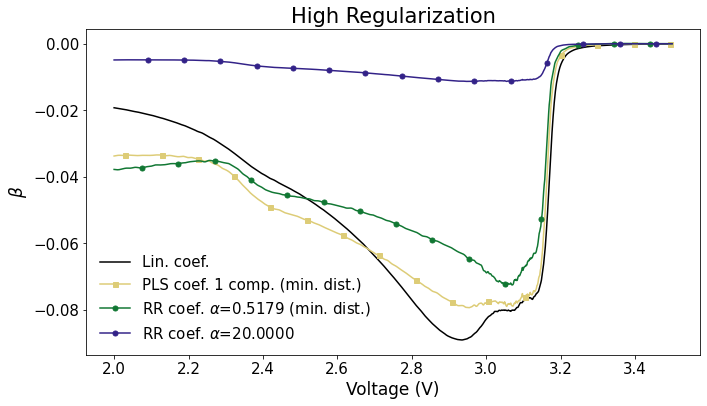

In [25]:
# Make the plots for the manuscript
fig, ax = plot_ridge_regression(
    alpha=20, nb_comp=1, rr=True, pls=False, x=x_lfp, X=X,
    std=False, y_selection='Sum of Squares', cv_pls=False, cv_rr=False, mind_pls=True, mind_rr=True, 
    cv_std_pls=False, cv_std_rr=False, return_fig=True)

ax.set_title('High Regularization')
# Save fig
fig.savefig('figures/sos_hr.pdf', bbox_inches='tight')

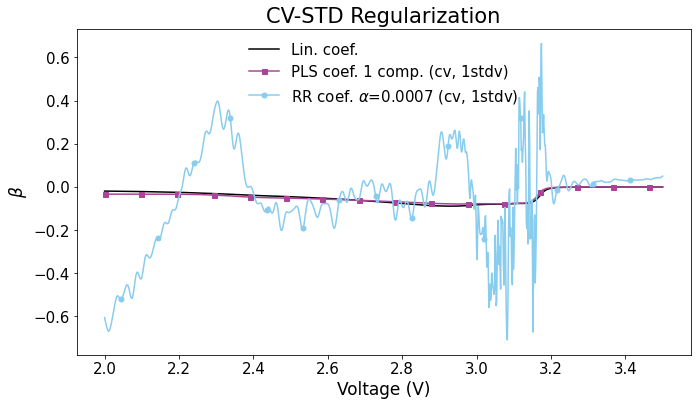

In [26]:
# Make the plots for the manuscript
fig, ax = plot_ridge_regression(
    alpha=5, nb_comp=1, rr=False, pls=False, x=x_lfp, X=X,
    std=False, y_selection='Sum of Squares', cv_pls=False, cv_rr=False, mind_pls=False, mind_rr=False, 
    cv_std_pls=True, cv_std_rr=True, return_fig=True)

ax.set_title('CV-STD Regularization')
# Save fig
fig.savefig('figures/sos_vc-std.pdf', bbox_inches='tight')

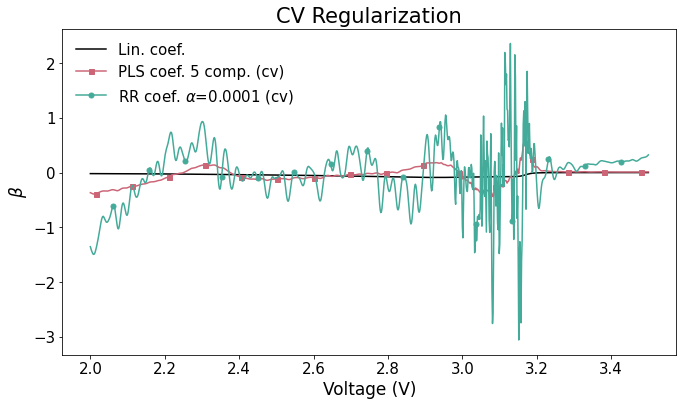

In [27]:
# Make the plots for the manuscript
fig, ax = plot_ridge_regression(
    alpha=5, nb_comp=10, rr=False, pls=False, x=x_lfp, X=X,
    std=False, y_selection='Sum of Squares', cv_pls=True, cv_rr=True, mind_pls=False, mind_rr=False, 
    cv_std_pls=False, cv_std_rr=False, return_fig=True)

ax.set_title('CV Regularization')
# Save fig
fig.savefig('figures/sos_cv.pdf', bbox_inches='tight')

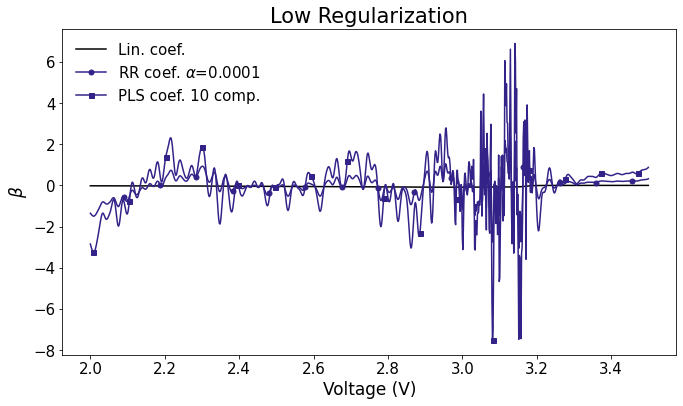

In [28]:
# Make the plots for the manuscript
fig, ax = plot_ridge_regression(
    alpha=0.0001, nb_comp=10, rr=True, pls=True, x=x_lfp, X=X,
    std=False, y_selection='Sum of Squares', cv_pls=False, cv_rr=False, mind_pls=False, mind_rr=False, 
    cv_std_pls=False, cv_std_rr=False, return_fig=True)

ax.set_title('Low Regularization')
# Save fig
fig.savefig('figures/sos_lr.pdf', bbox_inches='tight')

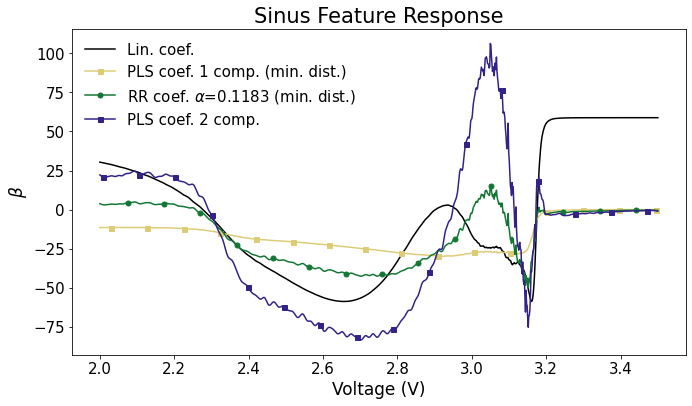

In [29]:
# Make the plots for the manuscript
fig, ax = plot_ridge_regression(
    alpha=1, nb_comp=2, rr=False, pls=True, x=x_lfp, X=X,
    std=False, y_selection='Sinus', cv_pls=False, cv_rr=False, mind_pls=True, mind_rr=True, 
    cv_std_pls=False, cv_std_rr=False, return_fig=True)

ax.set_title('Sinus Feature Response')
# Save fig
fig.savefig('figures/sinus_issues.pdf', bbox_inches='tight')

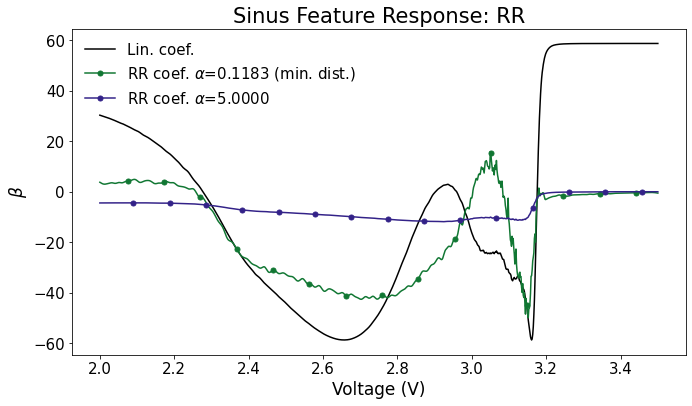

In [30]:
# Make the plots for the manuscript
# alpha = 0.03 # interesting value
fig, ax = plot_ridge_regression(
    alpha=5, nb_comp=2, rr=True, pls=False, x=x_lfp, X=X,
    std=False, y_selection='Sinus', cv_pls=False, cv_rr=False, mind_pls=False, mind_rr=True, 
    cv_std_pls=False, cv_std_rr=False, return_fig=True)

ax.set_title('Sinus Feature Response: RR')
# Save fig
fig.savefig('figures/sinus_issues_rr.pdf', bbox_inches='tight')

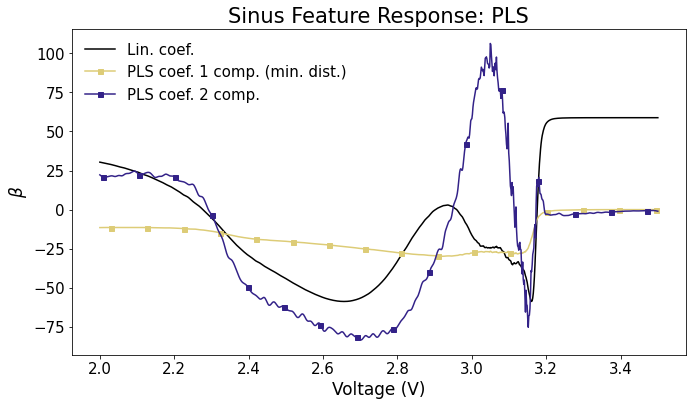

In [31]:
# Make the plots for the manuscript
fig, ax = plot_ridge_regression(
    alpha=1, nb_comp=2, rr=False, pls=True, x=x_lfp, X=X,
    std=False, y_selection='Sinus', cv_pls=False, cv_rr=False, mind_pls=True, mind_rr=False, 
    cv_std_pls=False, cv_std_rr=False, return_fig=True)

ax.set_title('Sinus Feature Response: PLS')
# Save fig
fig.savefig('figures/sinus_issues_pls.pdf', bbox_inches='tight')

In [32]:

# Move part of the paper about the param opt to the frist part. 
# Last section outlook with complications when compating features//limitations.
# Showcase standardization

# Issues: 
# 1. Try with cylce life reponse and plot the cv results
# BAse on that decidee whether to standardize the data or not for the main part of the paper
# Move the analysis of the cycle life to the SI section.

In [33]:
# Larger font
# make it a bit shorter... 

# Use the colors from above.

# Even though there are differences, they have very minor effects on the regression results. 
# Nullspace 

Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 2 comp', 'PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=6.9e-01 % is 16.632
Gamma value corresponding to nrmse=9.4e-02 % is 27.558


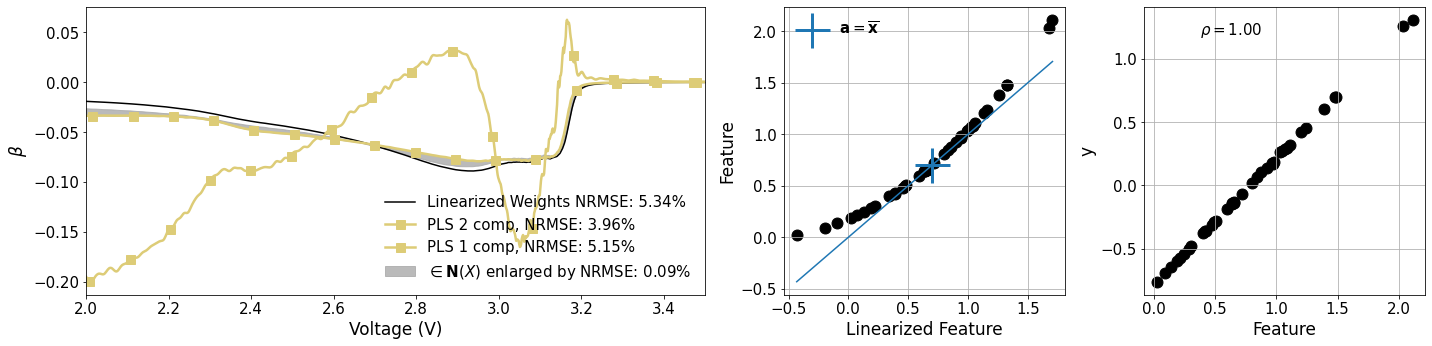

In [34]:
lfp_sums = lfp_sums.analyse_feature('Sum of Squares', opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['PLS']}, max_nrmse=-0.5)
fig, ax = lfp_sums.linearization_plot('Sum of Squares')
#fig.suptitle('Sinus Feature Nullspace Analysis, PLS')
# Save fig
fig.savefig('figures/sos_nulls_pls.pdf', bbox_inches='tight')


Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 2 comp', 'RR: 0.52478', 'lfun']
Gamma value corresponding to nrmse=6.9e-01 % is 16.632
Gamma value corresponding to nrmse=2.9e-01 % is 0.406


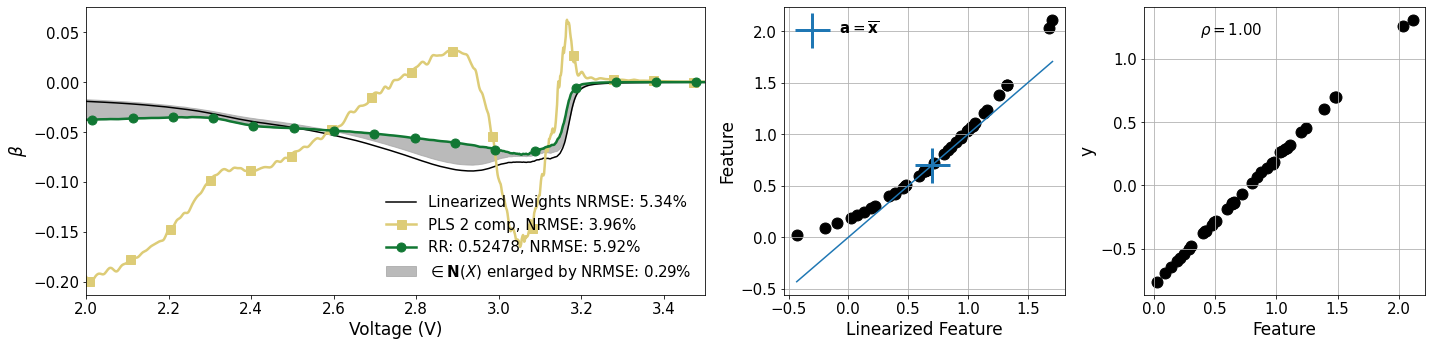

In [35]:
lfp_sums = lfp_sums.analyse_feature('Sum of Squares', opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['RR']}, max_nrmse=-0.5)
fig, ax = lfp_sums.linearization_plot('Sum of Squares')
#fig.suptitle('Sinus Feature Nullspace Analysis, RR')
fig.savefig('figures/sos_nulls_rr.pdf', bbox_inches='tight')

Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 2 comp', 'RR: 0.09325', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 106.798
Gamma value corresponding to nrmse=5.0e-02 % is 5.914


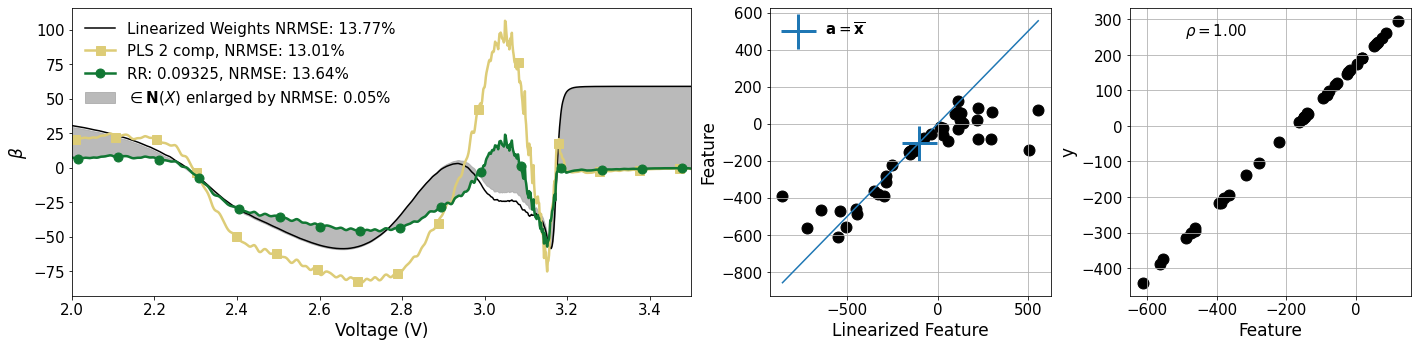

In [36]:
lfp_sin = lfp_sin.analyse_feature('Sinus Transformation', opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['RR']}, max_nrmse=0.05)
fig, ax = lfp_sin.linearization_plot('Sinus Transformation')
#fig.suptitle('Sinus Feature Nullspace Analysis, RR')
fig.savefig('figures/sinus_nulls_rr.pdf', bbox_inches='tight')

Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 2 comp', 'PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 106.798
Gamma value corresponding to nrmse=5.0e-02 % is 1751.755


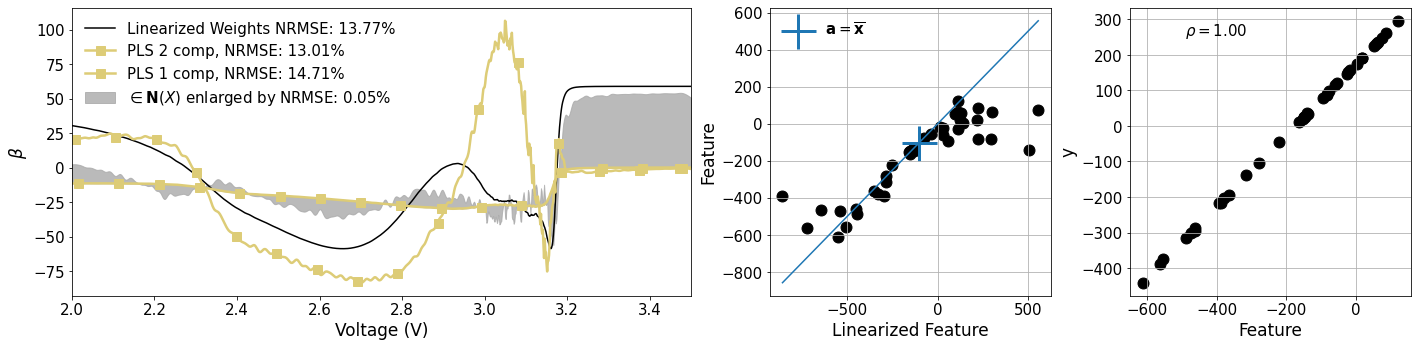

In [37]:
lfp_sin = lfp_sin.analyse_feature('Sinus Transformation', opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['PLS']}, max_nrmse=0.05)
fig, ax = lfp_sin.linearization_plot('Sinus Transformation')
#fig.suptitle('Sinus Feature Nullspace Analysis, RR')
fig.savefig('figures/sinus_nulls_pls.pdf', bbox_inches='tight')

Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 2 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 106.798


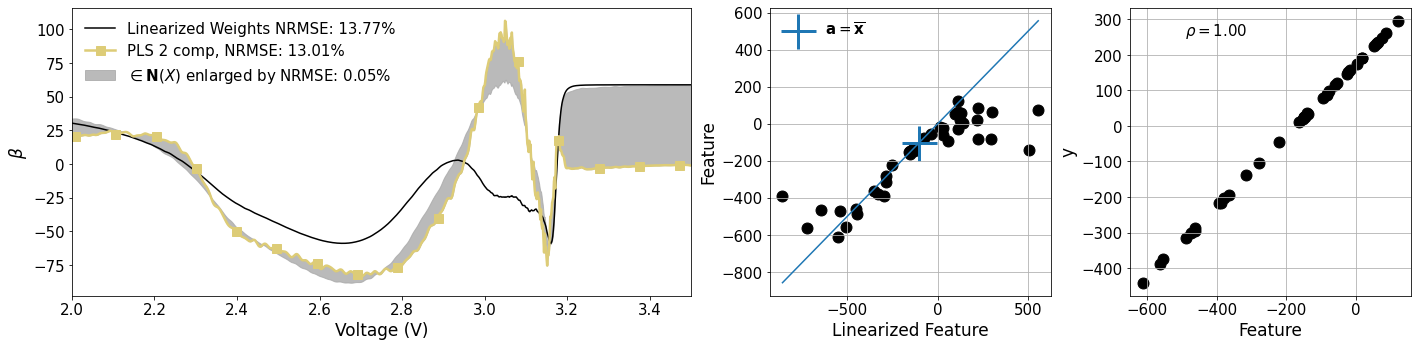

In [38]:
lfp_sin = lfp_sin.analyse_feature('Sinus Transformation', opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': []}, max_nrmse=0.05)
fig, ax = lfp_sin.linearization_plot('Sinus Transformation')
#fig.suptitle('Sinus Feature Nullspace Analysis, RR')
fig.savefig('figures/sinus_nulls_pls2.pdf', bbox_inches='tight')

In [39]:
# Make plots with the true cycle life response, to anaylse features


In [40]:
# Nullspace
# Use the two features: sums and sinus to show the nullspace

# LFP sums is a featlin object
# lfp_sums = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)
if 0: 
    lfp_sums = lfp_sums.analyse_all_features(opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['PLS']}, max_nrmse=0.1)